# <center>💻 Laptop Price Prediction using Machine Learning (Tunisia Market)</center>

This notebook aims to build a predictive model to estimate laptop prices using real product data scraped from Tunisian online electronics stores. 

In this project, I use features like RAM, processor type, screen size, storage, GPU, and more to accurately estimate laptop prices.

**Goals:**
- Explore and understand the dataset
- Visualize key relationships
- Build regression models
- Evaluate model performance

**Dataset**

- Data sourced from Tunisian online retailers (MyTek, Spacenet, Tdiscount, Agora, Batam, Graiet, Tunisianet)  
- Scraped using **BeautifulSoup** and **requests** in Python  
- Full scraping and cleaning process is available in the GitHub project:  
  👉 [GitHub - Laptop Price Scraping & Cleaning Project](https://github.com/ibtihel-dhaouadi/laptop-price-prediction-tn)

## 📊 Import Libraries & Load Data

In [1]:
!pip install lazypredict

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import joblib
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import category_encoders as ce

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set seaborn theme
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.figsize'] = (6, 4)

In [3]:
# Load dataset
df = pd.read_csv('/kaggle/input/tunisia-laptop-market-cleaned-dataset-2025/tunisia_laptop_prices_2025.csv')

In [4]:
df.head(3)

,reference,link,name,brand,image_url,store,screen_size,processor,ram,SSD,HDD,gpu,os,gamer,price
0,X515KA-EJ008,https://agora.tn/fr/pc-portable/16616-pc-porta...,PC PORTABLE ASUS X515KA CELERON N4500U 4GO 256...,Asus,https://agora.tn/fr/46133-home_default/pc-port...,agora,15.60,Intel Celeron,4,256,0,Integrated Graphics,FreeDos,0,719.00
1,X1504VA-NJ520W,https://agora.tn/fr/pc-portable/15389-pc-porta...,PC PORTABLE ASUS VIVOBOOK 15 X1504VA I3-1315U ...,Asus,https://agora.tn/fr/43259-home_default/pc-port...,agora,15.60,Intel Core i3,4,256,0,Integrated Graphics,Windows,0,1049.00
2,INS-3535-R5,https://agora.tn/fr/pc-portable/16867-pc-porta...,PC PORTABLE DELL INSPIRON 3535 AMD RAYZEN 5 8G...,Dell,https://agora.tn/fr/46775-home_default/pc-port...,agora,15.60,AMD Ryzen 5,8,512,0,AMD,FreeDos,0,1169.00


In [5]:
# Drop unwanted columns
df.drop(['reference','store', 'link', 'name', 'image_url'], axis=1, inplace=True)

In [6]:
df.columns

Index(['brand', 'screen_size', 'processor', 'ram', 'SSD', 'HDD', 'gpu', 'os',
       'gamer', 'price'],
      dtype='object')

## 🔍 Data Overview

In [7]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
brand,2429,10,Lenovo,666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
screen_size,2429.00,NaN,NaN,NaN,15.12,0.86,13.00,14.00,15.60,15.60,17.30
processor,2429,14,Intel Core i5,829,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ram,2429.00,NaN,NaN,NaN,18.60,10.28,4.00,8.00,16.00,24.00,64.00
SSD,2429.00,NaN,NaN,NaN,515.06,209.15,0.00,512.00,512.00,512.00,2048.00
HDD,2429.00,NaN,NaN,NaN,20.34,109.18,0.00,0.00,0.00,0.00,1024.00
gpu,2429,6,Nvidia GeForce,929,NaN,NaN,NaN,NaN,NaN,NaN,NaN
os,2429,6,Windows,1298,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gamer,2429.00,NaN,NaN,NaN,0.29,0.46,0.00,0.00,0.00,1.00,1.00
price,2429.00,NaN,NaN,NaN,2644.13,1442.93,629.00,1719.00,2449.00,3149.00,13999.00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2429 entries, 0 to 2428
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   brand        2429 non-null   object 
 1   screen_size  2429 non-null   float64
 2   processor    2429 non-null   object 
 3   ram          2429 non-null   int64  
 4   SSD          2429 non-null   int64  
 5   HDD          2429 non-null   int64  
 6   gpu          2429 non-null   object 
 7   os           2429 non-null   object 
 8   gamer        2429 non-null   int64  
 9   price        2429 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 189.9+ KB


In [9]:
df.isna().sum()

brand          0
screen_size    0
processor      0
ram            0
SSD            0
HDD            0
gpu            0
os             0
gamer          0
price          0
dtype: int64

From the above, we can see that the dataset is clean and ready for modeling. We have:
- 15 features
- 0 missing values
- Price is our target variable

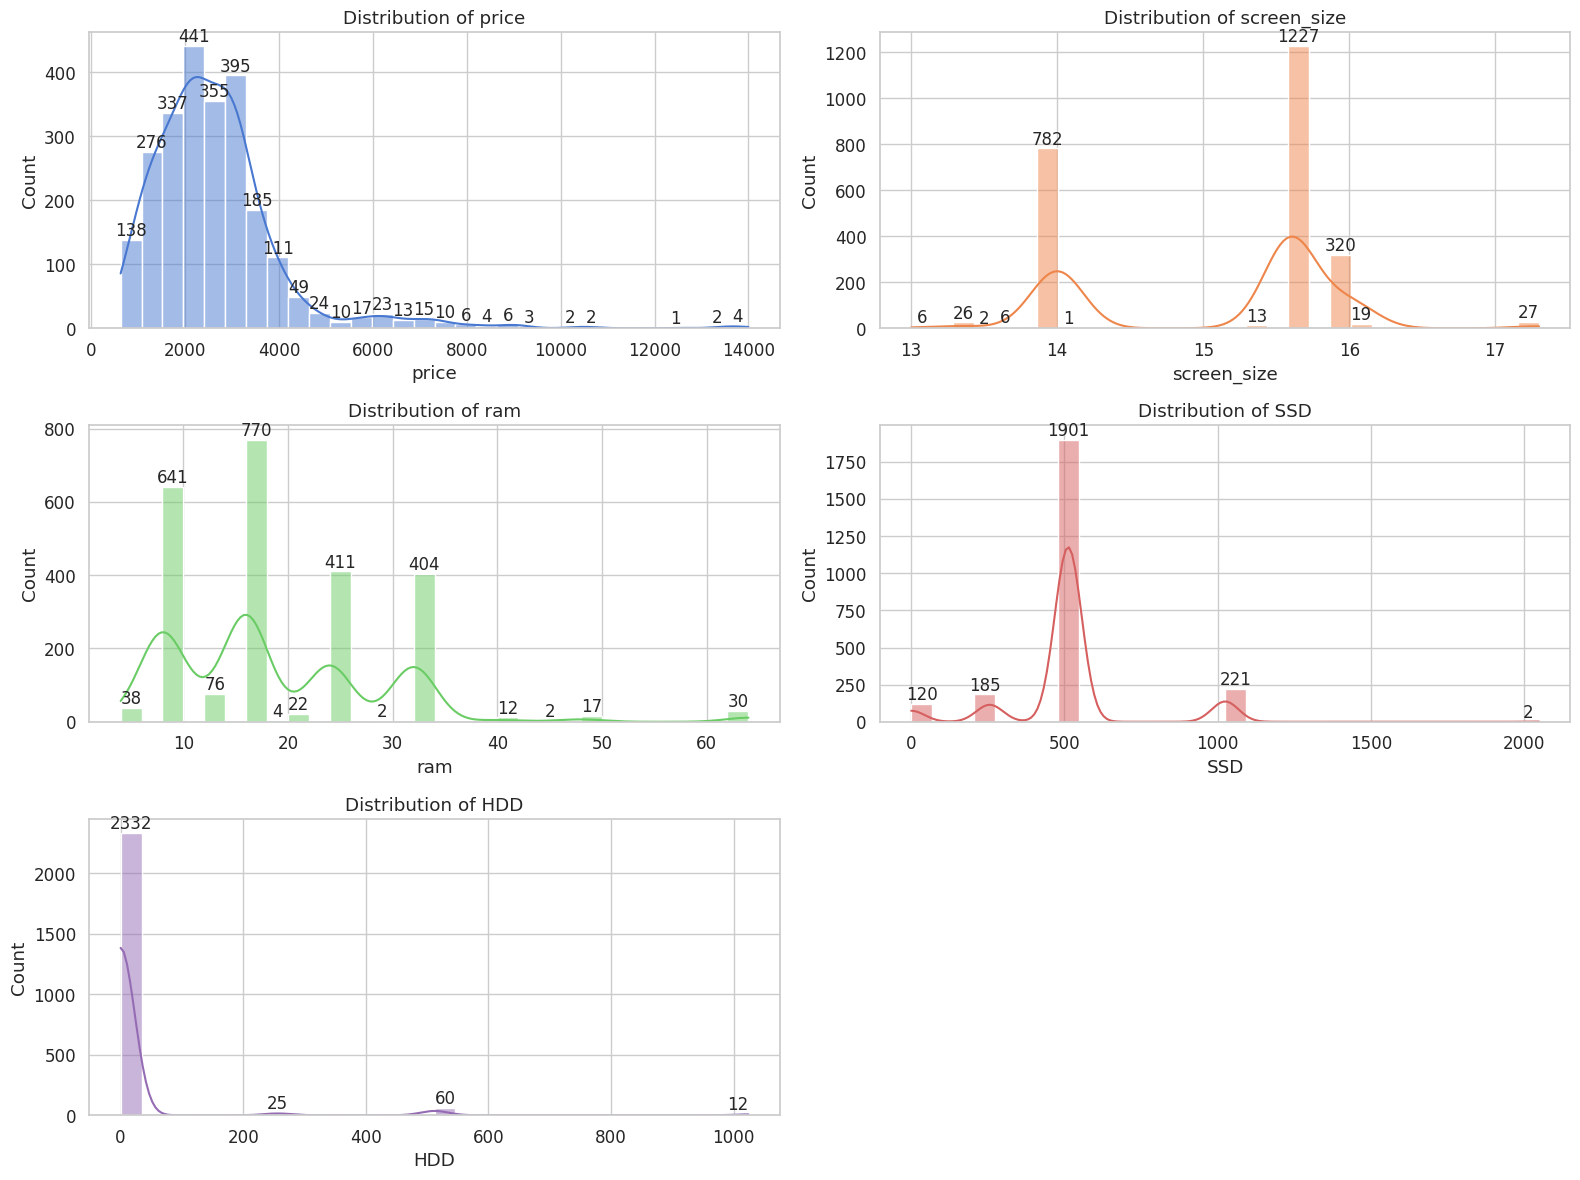

In [10]:
# NUMERIC DISTRIBUTIONS with count labels
numeric_cols = ['price', 'screen_size', 'ram', 'SSD', 'HDD']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    plot = sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color=sns.color_palette()[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    
    # Add count labels above bars
    for patch in plot.patches:
        height = patch.get_height()
        if height > 0:
            x = patch.get_x() + patch.get_width() / 2
            plot.text(x, height, f'{int(height)}', ha='center', va='bottom', fontsize=12, rotation=0)

# Remove empty subplot if needed
if len(numeric_cols) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

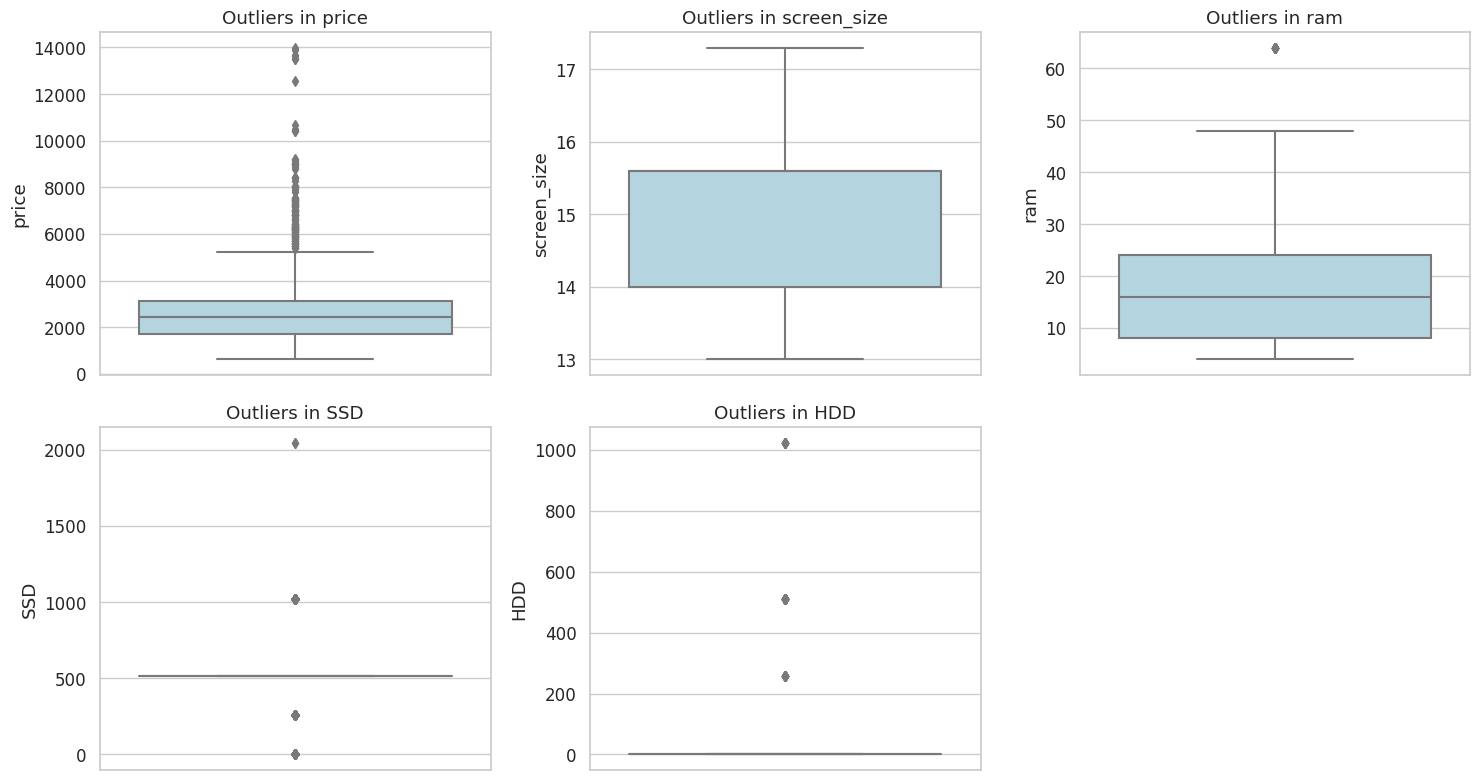

In [11]:
# Create boxplots
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(f'Outliers in {col}')
    plt.tight_layout()
plt.show()

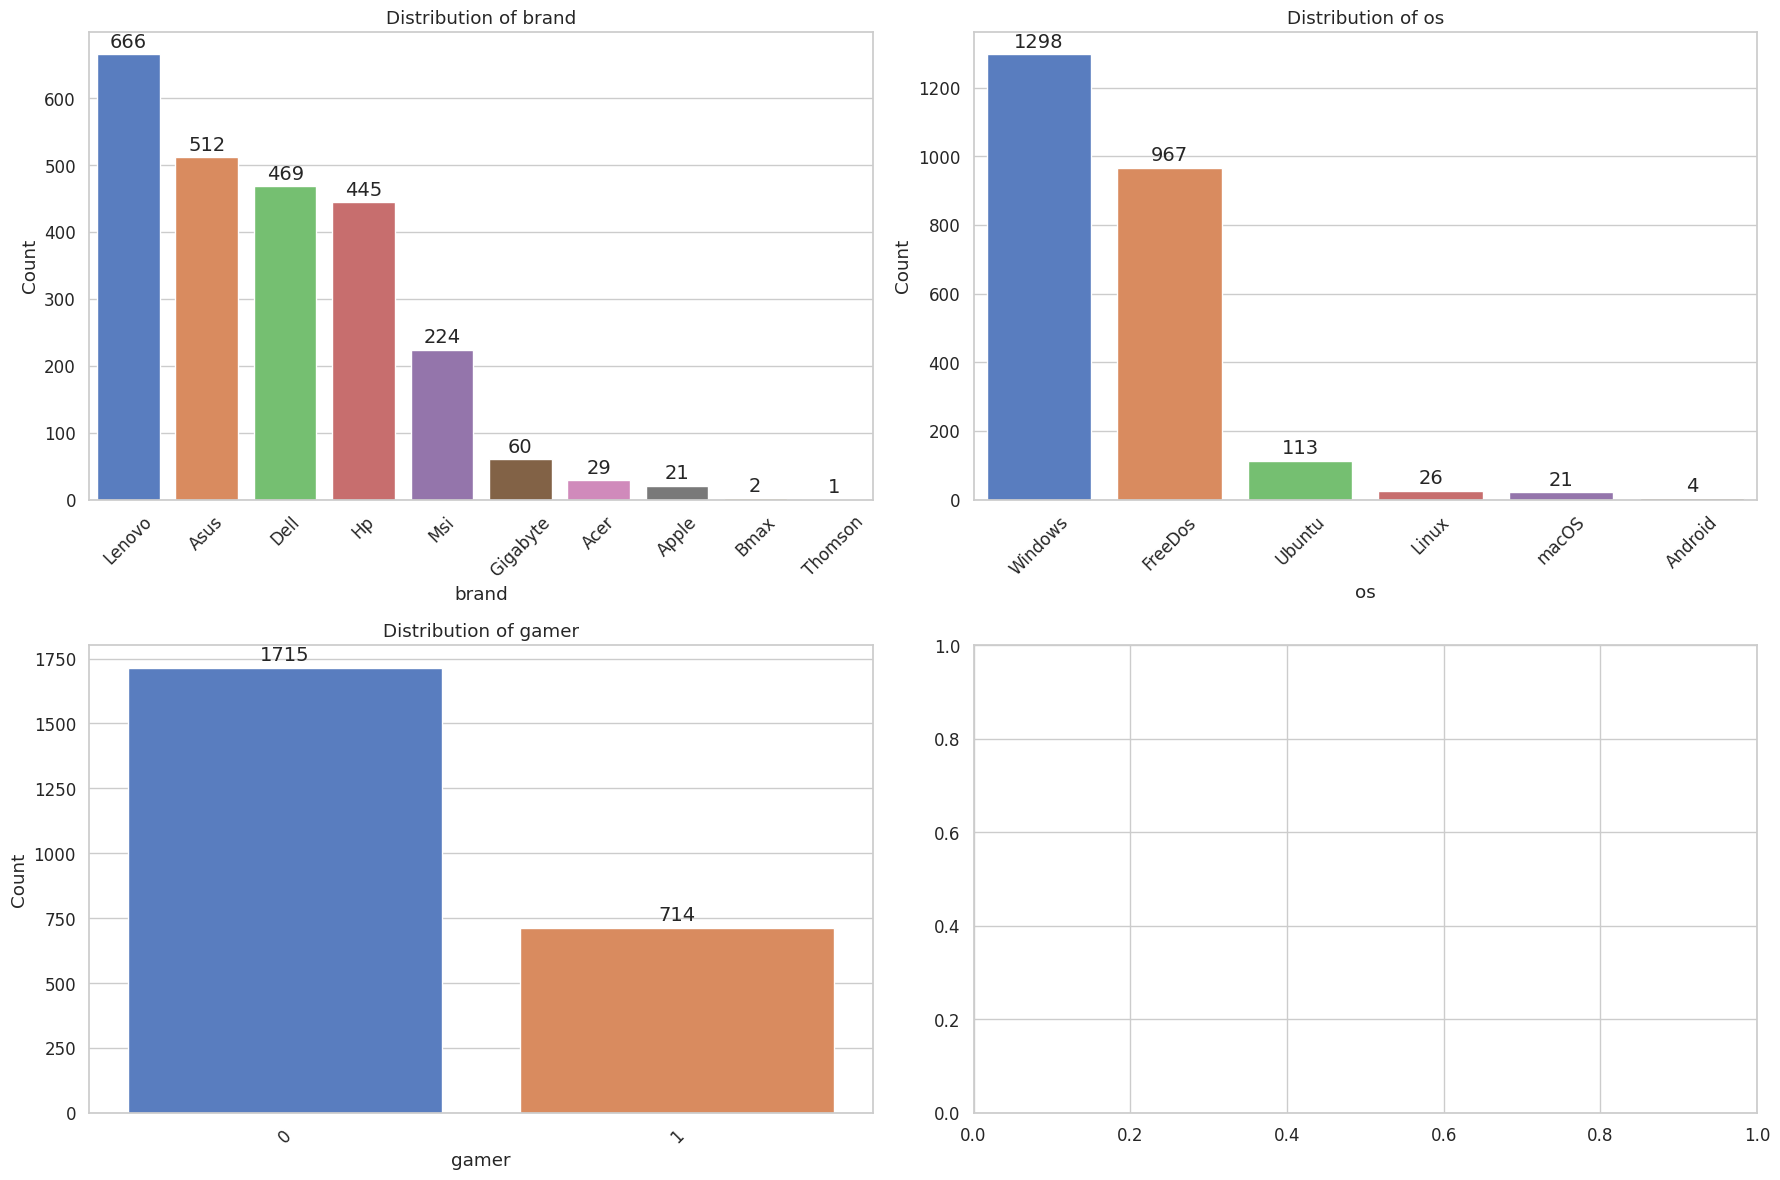

In [12]:
# CATEGORICAL DISTRIBUTIONS
# Categorical columns with moderate cardinality
cat_cols = ['brand', 'os', 'gamer']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    plot = sns.countplot(data=df, x=col, ax=axes[i], order=df[col].value_counts().index)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

    # Add count labels
    for container in plot.containers:
        plot.bar_label(container, fmt='%d', label_type='edge', padding=2, fontsize=14)

plt.tight_layout()
plt.show()

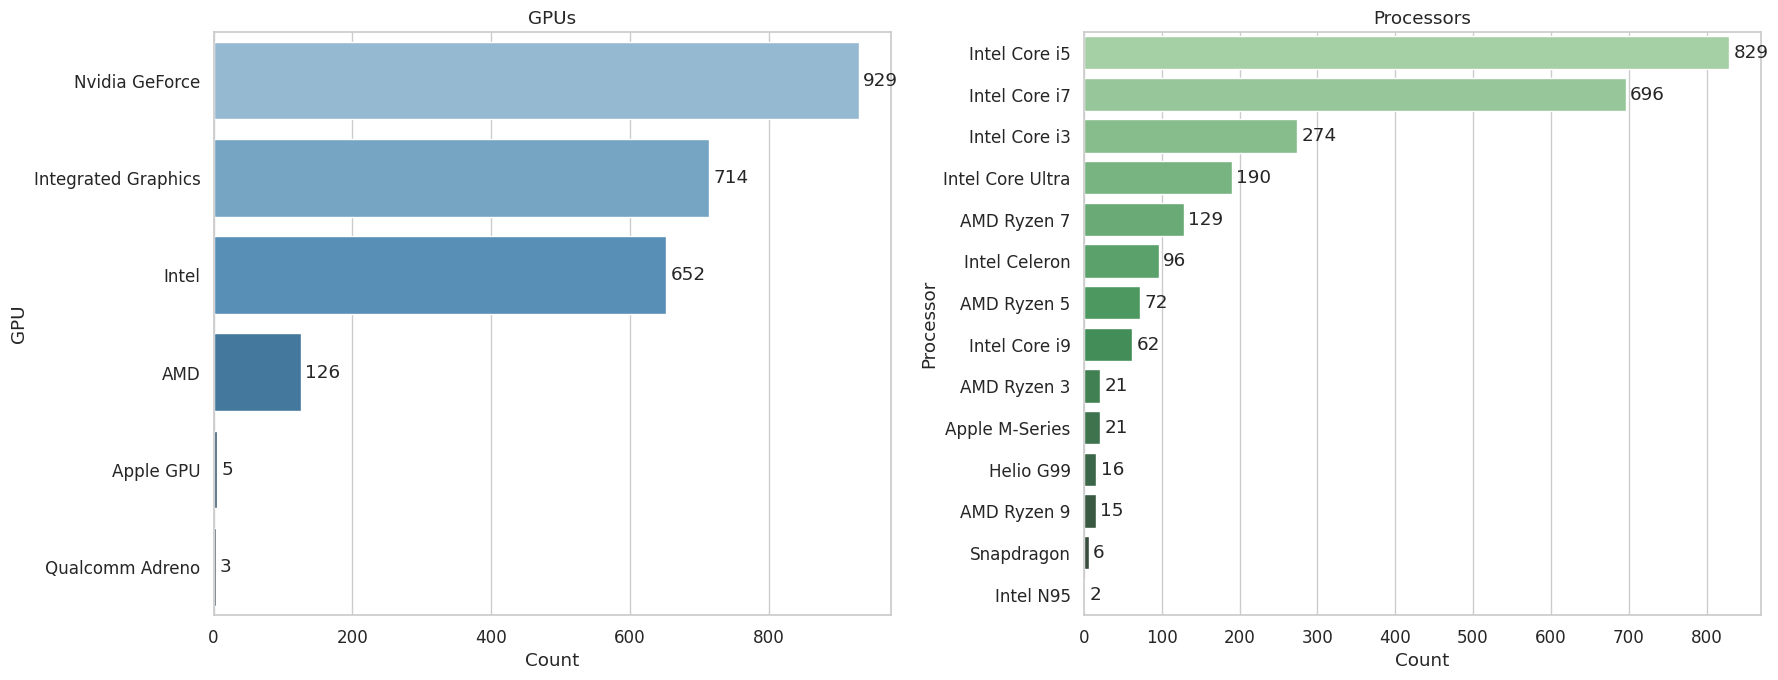

In [13]:
# GPUs and PROCESSORS
gpus = df['gpu'].value_counts()
procs = df['processor'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# GPU Plot
gpu_plot = sns.barplot(x=gpus.values, y=gpus.index, ax=axes[0], palette='Blues_d')
axes[0].set_title("GPUs")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("GPU")

# Add labels
for container in gpu_plot.containers:
    gpu_plot.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Processor Plot
proc_plot = sns.barplot(x=procs.values, y=procs.index, ax=axes[1], palette='Greens_d')
axes[1].set_title("Processors")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Processor")

# Add labels
for container in proc_plot.containers:
    proc_plot.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.tight_layout()
plt.show()


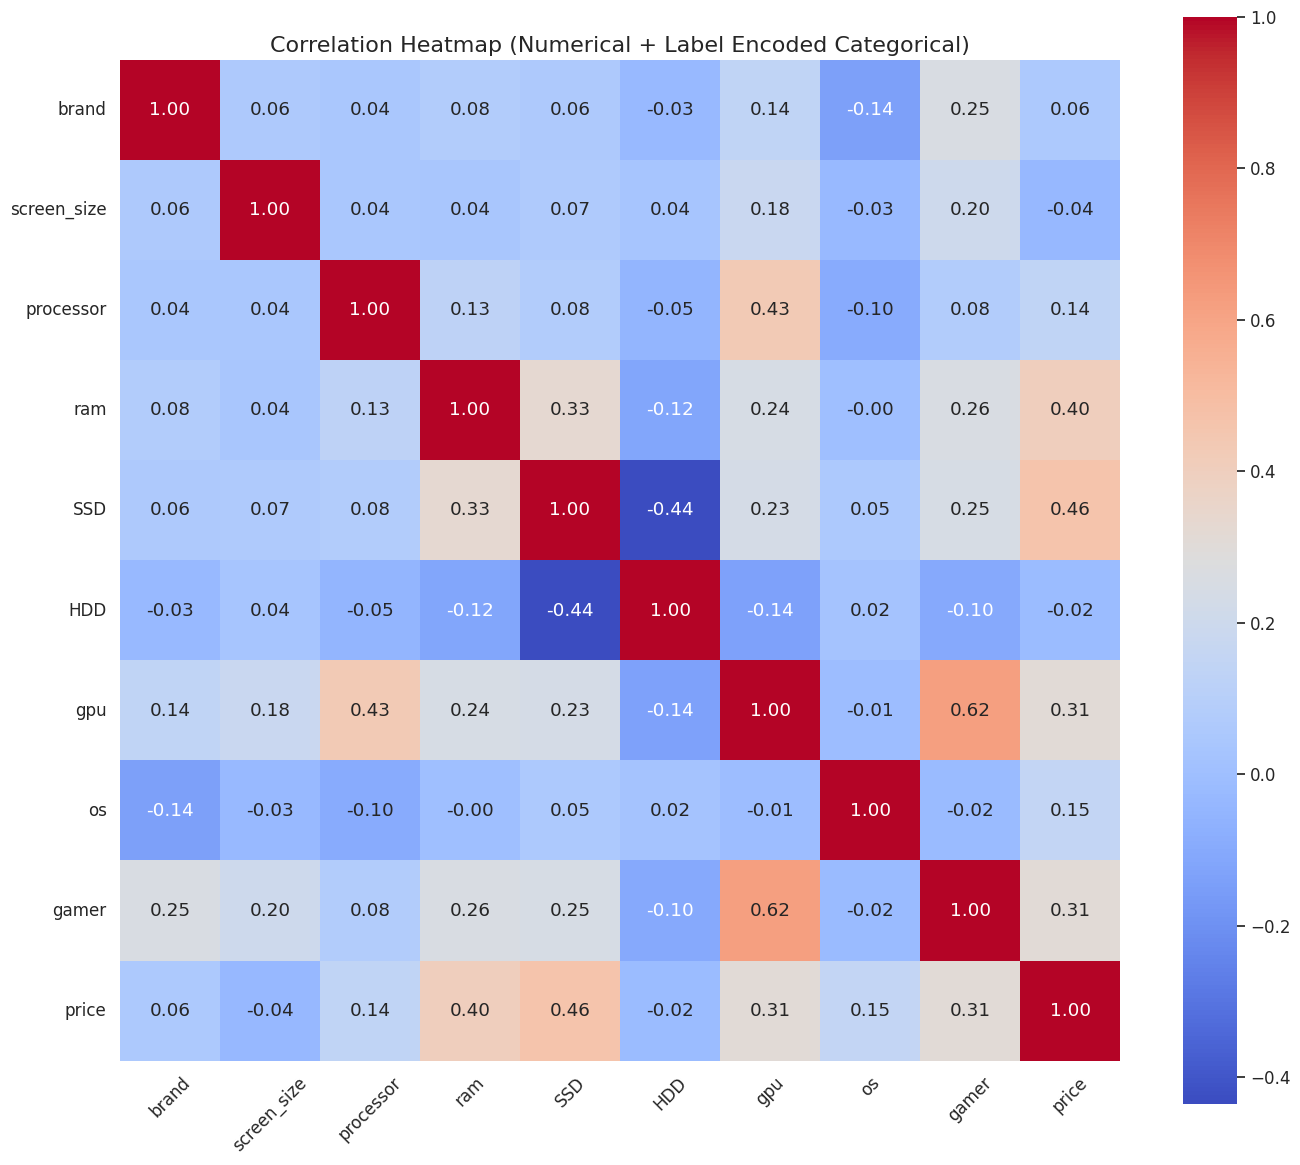

In [14]:
df_heatmap = df.copy()

# Identify categorical columns
categorical_cols = df_heatmap.select_dtypes(include=['object']).columns

# Label encode categorical columns for correlation calculation (heatmap)
le = LabelEncoder()
for col in categorical_cols:
    df_heatmap[col] = le.fit_transform(df_heatmap[col])

# Compute correlation matrix
corr_matrix = df_heatmap.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Heatmap (Numerical + Label Encoded Categorical)', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 🔧 Prepare data for modeling with Target Encoding

In [15]:
# Separate target
X = df.drop(columns=['price'])
y = df['price']

In [16]:
# Target Encoding
categorical_cols = X.select_dtypes(include='object').columns.tolist()
encoder = ce.TargetEncoder(cols=categorical_cols)
X_encoded = encoder.fit_transform(X, y)

In [17]:
# Log transform target
y_log = np.log1p(y)

In [18]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_log, test_size=0.3, random_state=42, shuffle=True
)

## 🤖 Train Models using LazyRegressor

In [19]:
reg = LazyRegressor(verbose=1, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7496095679037913, 'Adjusted R-Squared': 0.7464753344005008, 'RMSE': 0.25104551163314975, 'Time taken': 0.13093090057373047}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8453542524195509, 'Adjusted R-Squared': 0.8434184920186829, 'RMSE': 0.19729341379287285, 'Time taken': 0.05434846878051758}
{'Model': 'BayesianRidge', 'R-Squared': 0.7517435633592597, 'Adjusted R-Squared': 0.7486360418992226, 'RMSE': 0.24997343326067062, 'Time taken': 0.01173257827758789}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8244273242838089, 'Adjusted R-Squared': 0.822229613461214, 'RMSE': 0.2102190456989986, 'Time taken': 0.013749122619628906}
{'Model': 'DummyRegressor', 'R-Squared': -3.19292059838272e-05, 'Adjusted R-Squared': -0.012549714133457845, 'RMSE': 0.5017074263603042, 'Time taken': 0.008860349655151367}
{'Model': 'ElasticNet', 'R-Squared': -3.19292059838272e-05, 'Adjusted R-Squared': -0.012549714133457845, 'RMSE': 0.5017074263603042, 'Time taken': 0.

In [20]:
print("\nModel Comparison:")
models


Model Comparison:


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,0.88,0.88,0.17,0.16
LGBMRegressor,0.87,0.88,0.18,0.09
HistGradientBoostingRegressor,0.87,0.88,0.18,0.37
GradientBoostingRegressor,0.86,0.86,0.19,0.15
ExtraTreesRegressor,0.86,0.86,0.19,0.32
NuSVR,0.85,0.85,0.19,0.22
RandomForestRegressor,0.85,0.85,0.19,0.36
SVR,0.85,0.85,0.19,0.19
BaggingRegressor,0.84,0.85,0.20,0.05


## 📊 Fine-Tuning XGBoost Regressor with GridSearchCV

In [21]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.3], 
}

xgb = XGBRegressor(random_state=42)

grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, n_estim

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 6, 9],
                         'n_estimators': [100, 200]},
             scoring='r2', verbose=2)

In [22]:
print("✅ Best hyperparameters:", grid_search.best_params_)
print(f"✅ Best CV R² score: {grid_search.best_score_:.2f}", )

✅ Best hyperparameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
✅ Best CV R² score: 0.85


## 📈 Evaluate Model (XGBoost)

In [23]:
# Predict on test data
y_pred = grid_search.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print metrics
print("📈 Model Evaluation Metrics on Test Set:")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

📈 Model Evaluation Metrics on Test Set:
MAE (Mean Absolute Error): 0.13
RMSE (Root Mean Squared Error): 0.17
R² Score: 0.88


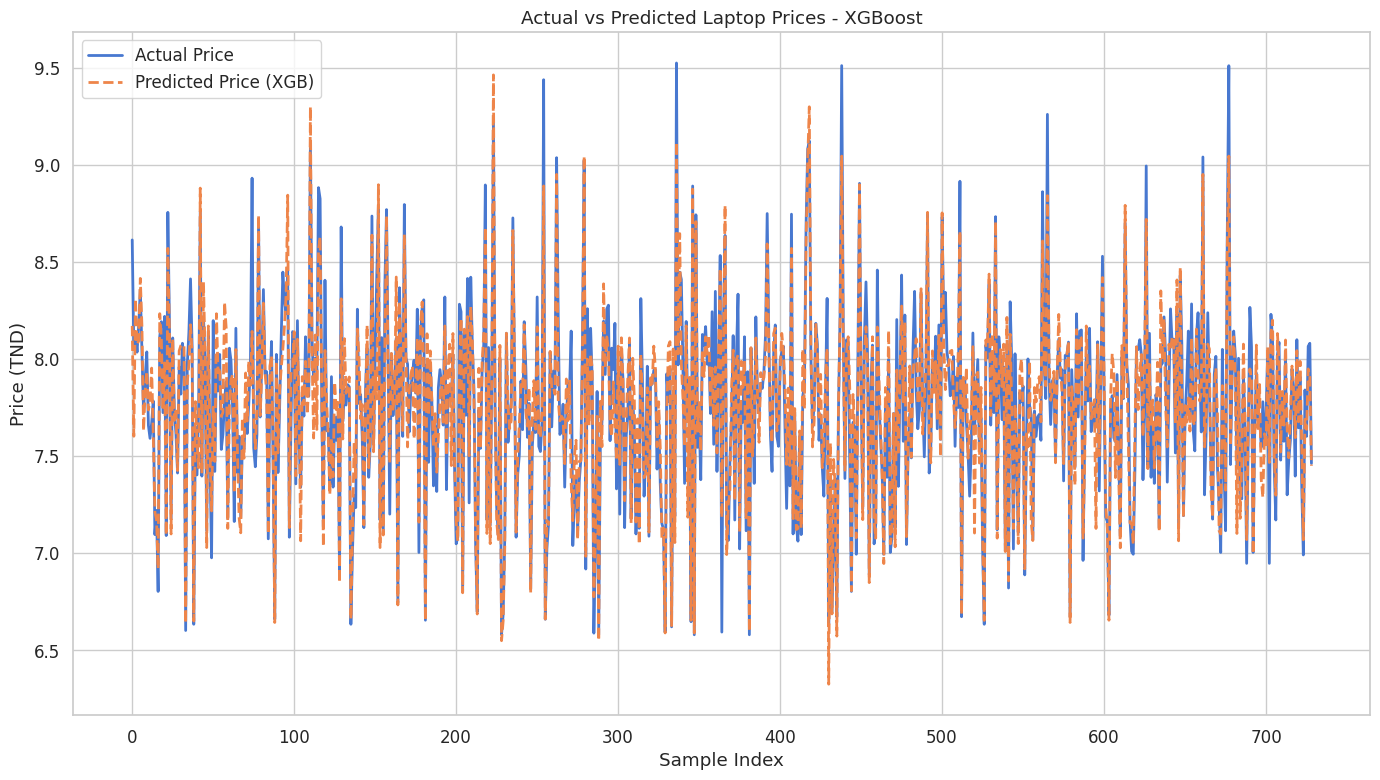

In [24]:
# Sort by index to maintain order
comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
}).reset_index(drop=True)

plt.figure(figsize=(14, 8))
plt.plot(comparison_df['Actual'], label='Actual Price', linewidth=2)
plt.plot(comparison_df['Predicted'], label='Predicted Price (XGB)', linestyle='--', linewidth=2)
plt.xlabel("Sample Index")
plt.ylabel("Price (TND)")
plt.title("Actual vs Predicted Laptop Prices - XGBoost")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

### Actual vs Predicted & Distribution

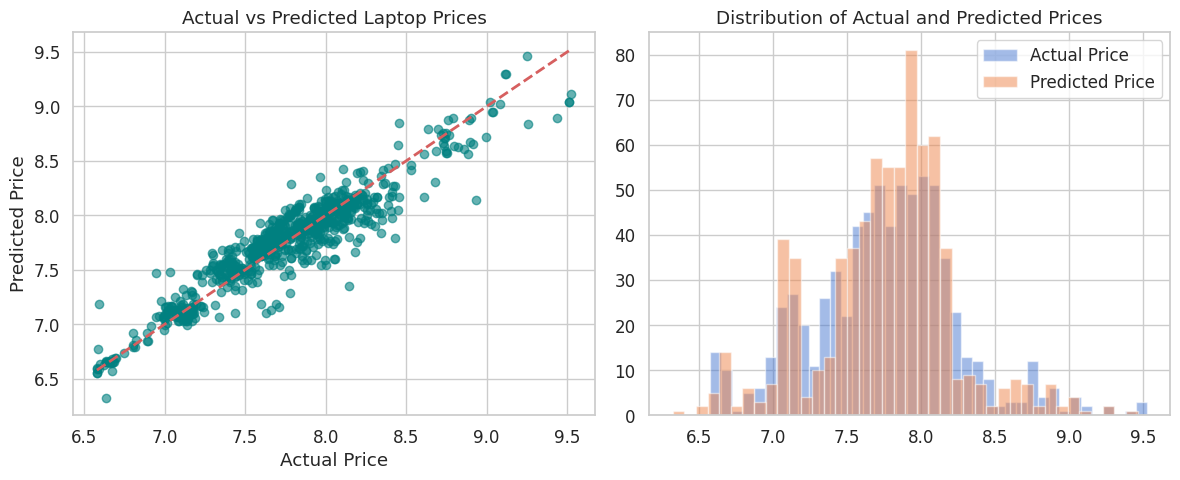

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left plot: Actual vs Predicted scatter
axes[0].scatter(y_test, y_pred, alpha=0.6, color='teal')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel("Actual Price")
axes[0].set_ylabel("Predicted Price")
axes[0].set_title("Actual vs Predicted Laptop Prices")
axes[0].grid(True)

# Right plot: Distribution comparison histogram
axes[1].hist(y_test, bins=40, alpha=0.5, label='Actual Price')
axes[1].hist(y_pred, bins=40, alpha=0.5, label='Predicted Price')
axes[1].legend()
axes[1].set_title("Distribution of Actual and Predicted Prices")

plt.tight_layout()
plt.show()

### Residual Analysis

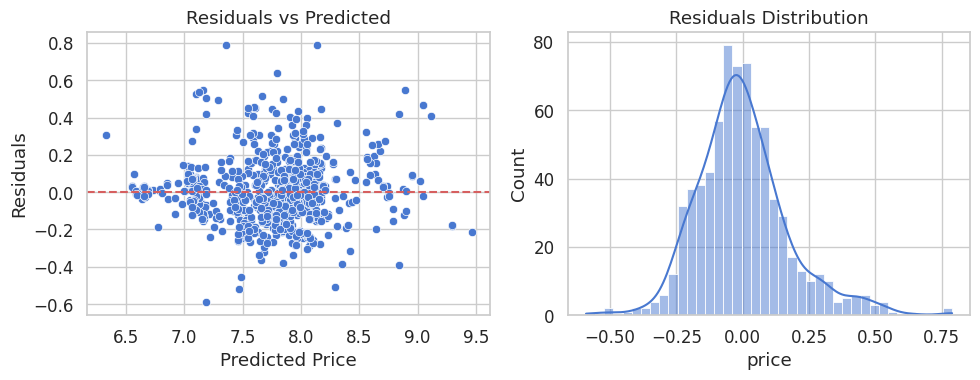

In [26]:
# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')

plt.subplot(1,2,2)
sns.histplot(residuals, bins=40, kde=True)
plt.title('Residuals Distribution')

plt.tight_layout()
plt.show()

## 🎯 Feature Importance (XGBoost)

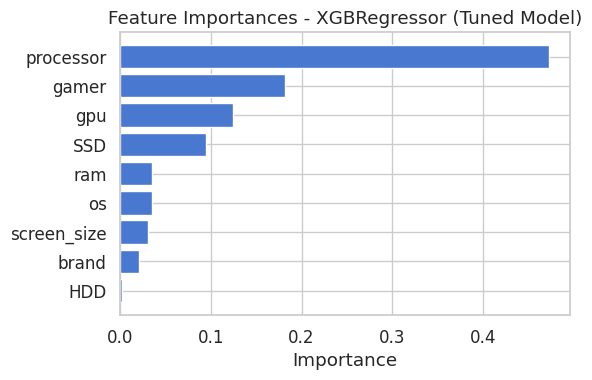

In [27]:
# Get the best estimator from grid search
best_xgb = grid_search.best_estimator_
 
# Feature importances
importances = best_xgb.feature_importances_
features = X_train.columns

# Sort features by importance (descending)
indices = np.argsort(importances)[::-1]

# Plot horizontal bar chart (transposed)
plt.figure(figsize=(6, 4))
plt.title("Feature Importances - XGBRegressor (Tuned Model)")
plt.barh(range(len(importances)), importances[indices][::-1], align='center')
plt.yticks(range(len(importances)), features[indices][::-1])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## ✅ Predict sample Using the Trained Model

In [28]:
sample = pd.DataFrame([{
    'brand': 'Lenovo',
    'screen_size': 15.6,
    'processor': 'AMD Ryzen 5',
    'ram': 16,
    'SSD': 512,
    'HDD': 0,
    'gpu': 'Integrated Graphics',
    'os': 'Windows',
    'gamer': 0
}])

In [29]:
# Apply the same target encoder
sample_encoded = encoder.transform(sample)

In [30]:
# Predict log(price)
predicted_log_price = grid_search.predict(sample_encoded)

# Inverse log1p to get real price
predicted_price = np.expm1(predicted_log_price)

print(f"Predicted laptop price: {predicted_price[0]:,.0f} TND")

Predicted laptop price: 1,382 TND


## 🚀 Conclusion

In [31]:
# Save the best tuned model
joblib.dump(grid_search.best_estimator_, 'xgb_best_tuned_model.joblib')

# Save the fitted TargetEncoder
joblib.dump(encoder, 'target_encoder.joblib')

['target_encoder.joblib']

- We successfully built a laptop price prediction model tailored to the Tunisian market using real data.

- The **XGBRegressor** model delivered strong performance with **low error metrics (MAE, RMSE)** and **solid R² scores**.

- Key features influencing price include **Processor type**, **SSD capacity**, and **Gaming suitability**.

**<center>✨ Stay tuned for the next step ✨<br>****<br>Building a laptop recommendation system to help users find the best laptops tailored to their needs and budget. 😊💻</center>**